Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (188318, 132)
   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.32157

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Trained in 94.5 s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


Evaluation on test set:
  R2_log: 0.5292
  MAE_log: 0.4317
  RMSE_log: 0.5542
  MAE_orig: 1192.8019
  MedianAE_orig: 695.9543
  RMSE_orig: 2040.3108

Top 25 features (full model):
   feature  importance
0    cat80    0.202595
1    cat79    0.115203
2   cat101    0.076791
3    cat12    0.046077
4    cat81    0.035011
5   cat103    0.027816
6    cont7    0.027167
7    cont2    0.027003
8   cont14    0.026926
9     cat1    0.025880
10   cat87    0.021917
11  cat111    0.020673
12  cat100    0.018685
13  cat114    0.017993
14   cat53    0.014095
15  cont11    0.013346
16  cont12    0.013279
17   cat72    0.012487
18   cont3    0.011784
19   cat57    0.010870
20    cat2    0.010444
21   cont6    0.010263
22   cat10    0.009776
23   cont1    0.009142
24   cont8    0.009047

Full model MAE (original scale): $1192.80

Selected top-25 features to re-fit model: ['cat80', 'cat79', 'cat101', 'cat12', 'cat81', 'cat103', 'cont7', 'cont2', 'cont14', 'cat1', 'cat87', 'cat111', 'cat100', 'cat114', 'cat

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Trained in 33.8 s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


Evaluation on test set:
  R2_log: 0.5180
  MAE_log: 0.4377
  RMSE_log: 0.5608
  MAE_orig: 1207.0284
  MedianAE_orig: 706.0404
  RMSE_orig: 2053.3519

Top-features model MAE (original scale): $1207.03

=== Comparison ===
Full model MAE (orig): $1192.80
Top-25 model MAE (orig): $1207.03
R2_log - Full: 0.5292, Top-25: 0.5180


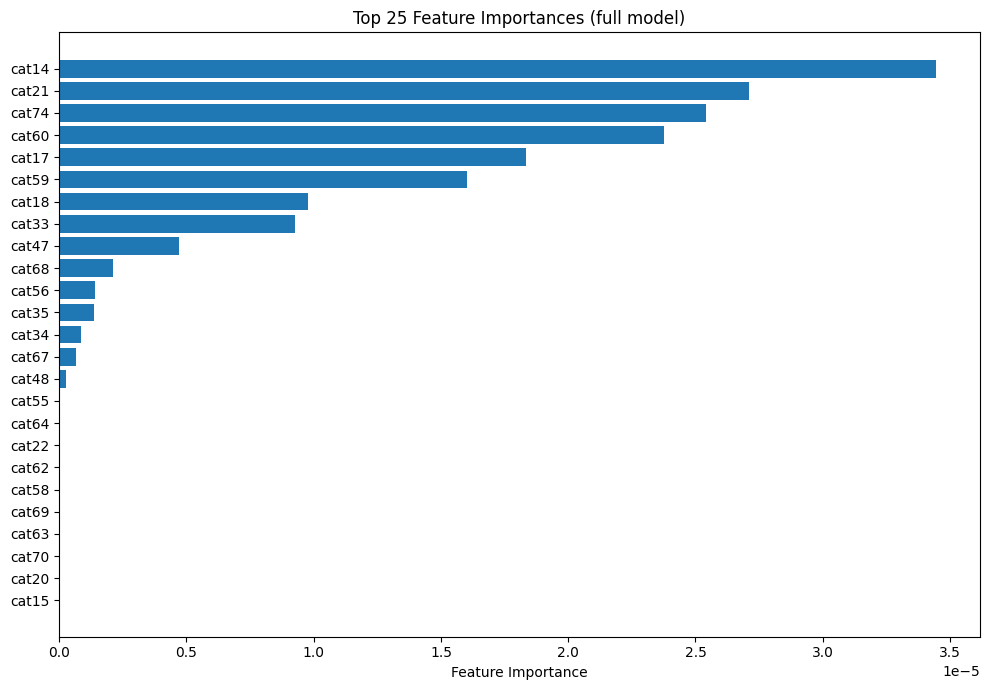

Inspecting residuals for the better model (lower MAE on original scale).


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


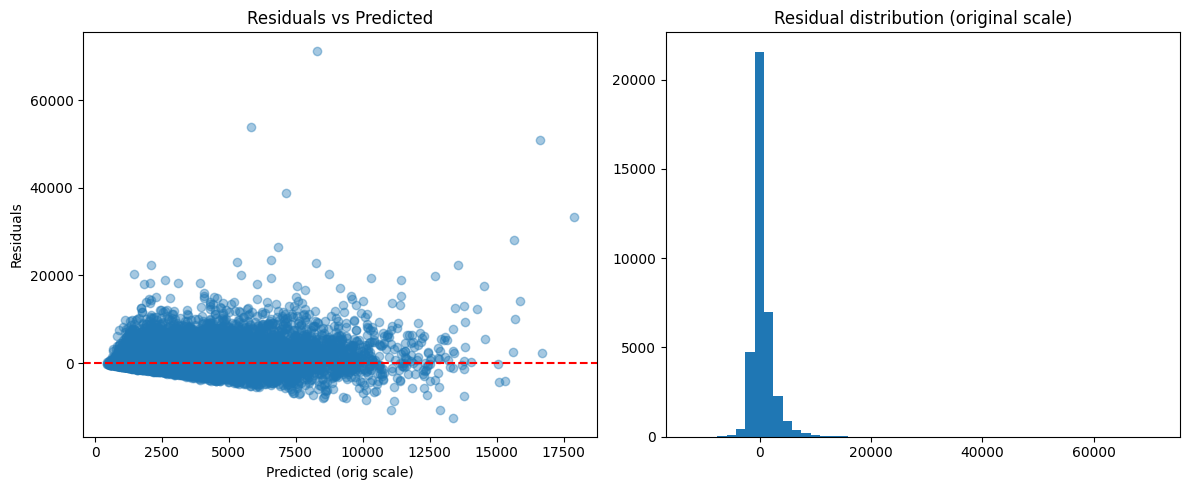

MAPE (using non-zero guard): 49.87%

=== Done ===


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
import matplotlib.pyplot as plt
import time

# --- Load the data (Colab)
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/claims_data (1).csv"
df = pd.read_csv(filepath)

print("Dataset shape:", df.shape)
print(df.head())
print("\nMissing values (per column):")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# --- Target transform
df['log_loss'] = np.log1p(df['loss'])
y = df['log_loss']

# --- Features
categorical_cols = [f'cat{i}' for i in range(1, 116)]
numerical_cols = [f'cont{i}' for i in range(1, 15)]
X = df[numerical_cols + categorical_cols]

# Quick sanity
print(f"Numerical features: {len(numerical_cols)}, Categorical features: {len(categorical_cols)}")

# --- Preprocessing (numerical median fill, categorical: fill, rare grouping, label-encode)
X_processed = X.copy()
label_encoders = {}

# Numerical imputation
X_processed[numerical_cols] = X_processed[numerical_cols].fillna(X_processed[numerical_cols].median())

# Categorical handling
rare_thresh = 0.01  # keep same logic but configurable
for col in categorical_cols:
    X_processed[col] = X_processed[col].fillna('MISSING').astype(str)

    # group rare categories (less than rare_thresh proportion)
    vc = X_processed[col].value_counts(normalize=True)
    rare_cats = vc[vc < rare_thresh].index
    if len(rare_cats) > 0:
        X_processed[col] = X_processed[col].replace(list(rare_cats), 'RARE')

    # label encode (simple)
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    label_encoders[col] = le

print("Preprocessing completed.")

# --- Train / Test split
# **Change to match Tahia's split used in ridge_regression.ipynb: no stratify, test_size=0.2, random_state=42**
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# --- Evaluation helper
def evaluate_model(y_true_log, y_pred_log):
    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)
    metrics = {
        'R2_log': r2_score(y_true_log, y_pred_log),
        'MAE_log': mean_absolute_error(y_true_log, y_pred_log),
        'RMSE_log': np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        'MAE_orig': mean_absolute_error(y_true_orig, y_pred_orig),
        'MedianAE_orig': median_absolute_error(y_true_orig, y_pred_orig),
        'RMSE_orig': np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    }
    return metrics

# --- Model training function for convenience
def train_and_report(X_tr, X_te, y_tr, y_te, rf_params, print_feature_importance=False, top_k=25):
    rf = RandomForestRegressor(**rf_params)
    # cross-val on training set
    cv_scores = cross_val_score(rf, X_tr, y_tr, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f"CV MAE (3-fold, train): {-cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

    start = time.time()
    rf.fit(X_tr, y_tr)
    train_time = time.time() - start
    print(f"Trained in {train_time:.1f} s")

    y_pred_log = rf.predict(X_te)
    metrics = evaluate_model(y_te, y_pred_log)
    print("Evaluation on test set:")
    for k, v in metrics.items():
        if k.endswith('_orig') or k.startswith('MAE') or k.startswith('RMSE'):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v:.4f}")

    if print_feature_importance:
        fi = pd.DataFrame({
            'feature': X_tr.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        display = fi.head(top_k).reset_index(drop=True)
        print(f"\nTop {top_k} features (full model):")
        print(display)
        return rf, metrics, fi
    return rf, metrics, None

# --- RF hyperparameters (kept similar to yours)
rf_params = dict(
    n_estimators=100,
    max_depth=20,
    max_features=0.3,
    min_samples_split=20,
    min_samples_leaf=10,
    max_samples=0.8,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 1) Fit full-feature model and get importances
print("\n--- Fitting Random Forest on ALL features ---")
rf_full, metrics_full, fi_full = train_and_report(X_train, X_test, y_train_log, y_test_log,
                                                   rf_params, print_feature_importance=True, top_k=25)

# Print test MAE in original scale for reporting
print(f"\nFull model MAE (original scale): ${metrics_full['MAE_orig']:.2f}")

# --- Select top 20-25 features
top_k = 25
fi_sorted = fi_full.sort_values('importance', ascending=False).reset_index(drop=True)
top_features = fi_sorted['feature'].iloc[:top_k].tolist()
print(f"\nSelected top-{top_k} features to re-fit model: {top_features}")

# 2) Refit using only top features
print(f"\n--- Re-fitting Random Forest using top {top_k} features ---")
X_train_top = X_train[top_features]
X_test_top  = X_test[top_features]

rf_top, metrics_top, _ = train_and_report(X_train_top, X_test_top, y_train_log, y_test_log,
                                         rf_params, print_feature_importance=False)

print(f"\nTop-features model MAE (original scale): ${metrics_top['MAE_orig']:.2f}")

# --- Compare and print both results side-by-side
print("\n=== Comparison ===")
print(f"Full model MAE (orig): ${metrics_full['MAE_orig']:.2f}")
print(f"Top-{top_k} model MAE (orig): ${metrics_top['MAE_orig']:.2f}")
print(f"R2_log - Full: {metrics_full['R2_log']:.4f}, Top-{top_k}: {metrics_top['R2_log']:.4f}")

# --- Optional: plot top feature importance from full model
fi_plot = fi_full.sort_values('importance', ascending=True).head(25)
plt.figure(figsize=(10,7))
plt.barh(fi_plot['feature'], fi_plot['importance'])
plt.xlabel('Feature Importance')
plt.title(f'Top {len(fi_plot)} Feature Importances (full model)')
plt.tight_layout()
plt.show()

# --- Residual diagnostics on best model (choose which to inspect)
# Choose model_to_inspect = rf_top if metrics_top['MAE_orig'] <= metrics_full['MAE_orig'] else rf_full
model_to_inspect = rf_top if metrics_top['MAE_orig'] <= metrics_full['MAE_orig'] else rf_full
print("Inspecting residuals for the better model (lower MAE on original scale).")

# predictions, residuals
if model_to_inspect is rf_top:
    preds_log = model_to_inspect.predict(X_test_top)
else:
    preds_log = model_to_inspect.predict(X_test)

preds_orig = np.expm1(preds_log)
y_test_orig = np.expm1(y_test_log)
residuals_orig = y_test_orig - preds_orig

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(preds_orig, residuals_orig, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted (orig scale)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(1,2,2)
plt.hist(residuals_orig, bins=50)
plt.title('Residual distribution (original scale)')
plt.tight_layout()
plt.show()

# --- Print MAPE (with protection against division by zero)
safe_y = y_test_orig.copy()
safe_y[safe_y == 0] = 1e-6
mape = np.mean(np.abs(residuals_orig / safe_y)) * 100
print(f"MAPE (using non-zero guard): {mape:.2f}%")

print("\n=== Done ===")
